In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from math import sqrt, sin, cos

In [2]:
# We can define Milstein as follows (Proposition 4.6.6), as sigma is 1 dimensional, hence verifies Milstein approximation
def Milstein1D(T, xi, mu, sigma, sigma_P, W):
    N, M = W.shape[0], W.shape[1]
    N -= 1
    X = np.full(M, xi)
    
    for i in range(N):
        dW = W[i+1, :] - W[i, :]
        dt = T / N
        X = X + mu(X) * dt + sigma(X) * dW + 0.5 * sigma(X) * sigma_P(X) * (dW**2 - dt)
        
    return X


In [3]:
def mu_1(x):
    return x

def sigma_1(x):
    return 1 + np.log(x**2)

def sigma_1_P(x):
    return 2/x

def compute_Milstein(M, T, L, N, mu, sigma, sigma_P, xi):
    # Define the finest level in which it will be computed the "real" value X_T, using l = 7
    N_finest = 10*2**L[-1]
    W_inc = np.random.normal(0, sqrt(T/N_finest), (N_finest, M))
    W = np.vstack([np.zeros((1, M)), np.cumsum(W_inc, axis=0)])

    # Compute M realizations of Y_N for each level N_l
    Y_N_l = np.empty(len(L), dtype=object)
    for i, N_l in enumerate(N):
        step = N_finest / N_l
        Nl_indices = np.arange(0, N_finest + step, step, dtype=int)
        W_l = W[Nl_indices]
        Y_N_l[i] = Milstein1D(T, xi, mu, sigma, sigma_P, W_l)

    return Y_N_l



In [6]:
def strong_convergence(L, T, N, Y_N_l):
    strong_L1 = np.zeros(len(L)-1)
    for l in range(len(L)-1):
        strong_L1[l] = np.mean(np.abs(Y_N_l[l] - Y_N_l[-1]))

    strong_L2 = np.zeros(len(L)-1)
    for l in range(len(L)-1):
        strong_L2[l] = np.mean(np.abs(Y_N_l[l] - Y_N_l[-1]) ** 2) ** (1/2)

    plt.plot(N[:-1], strong_L1, label='L1 strong error') 
    plt.plot(N[:-1], strong_L2, label='L2 strong error') 
    plt.legend()
    plt.show()

    # Vector of time step sizes
    hv = T / (10 * 2**np.arange(5))

    # Compute convergence rates
    r1 = np.polyfit(np.log(hv), np.log(strong_L1), 1)
    print(f'Strong rate of convergence in L^1: {r1[0]}')

    r2 = np.polyfit(np.log(hv), np.log(strong_L2), 1)
    print(f'Strong rate of convergence in L^2: {r2[0]}')

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.loglog(hv, strong_L1, '-x', label='$L^1$-error')
    plt.loglog(hv, strong_L2, '-o', label='$L^2$-error')
     
    plt.loglog(hv, np.exp(r1[1]) * hv**r1[0], '--', label=f'$O(h^{{{r1[0]:.1f}}})$')
    plt.loglog(hv, np.exp(r2[1]) * hv**r2[0], '--', label=f'$O(h^{{{r2[0]:.1f}}})$')

    plt.legend(loc='best')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xlabel('Time step size $h$')
    plt.ylabel('Strong error')
    plt.title('Milstein Method: Strong Error')
    plt.show()

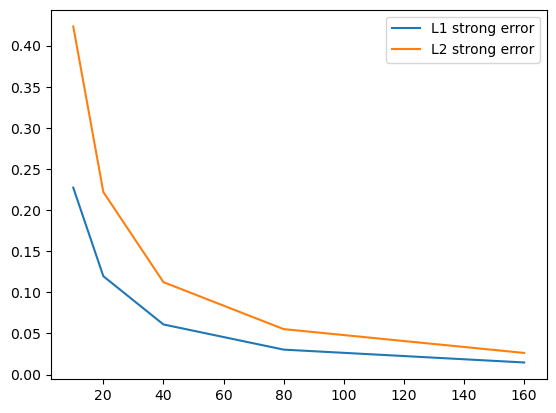

Strong rate of convergence in L^1: 0.9891032078912444
Strong rate of convergence in L^2: 1.0027071794197202


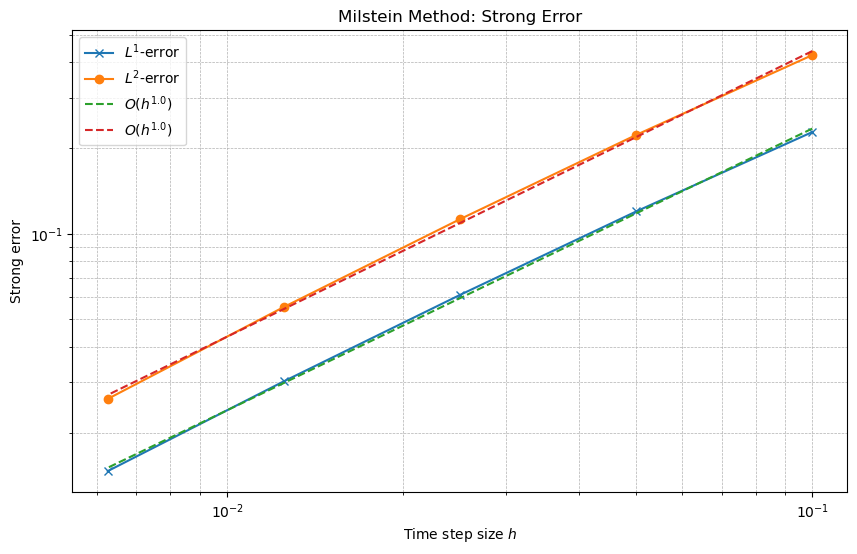

In [7]:
M = 10**5
T = 1
L = [0, 1, 2, 3, 4, 7]
xi = 1
N = [10*2**L[0], 10*2**L[1], 10*2**L[2], 10*2**L[3], 10*2**L[4], 10*2**L[5]]
Y_N_l = compute_Milstein(M, T, L, N, mu_1, sigma_1, sigma_1_P, xi)
strong_convergence(L, T, N, Y_N_l)

We see an strong error of order 1 for both p, which is correct acording to the theoretical strong convergence. Nevertheless, we are not considering the work to calculate this approximation, i.e., we are assuming that we get the real expected value from the montecarlo average without considering the amount of iterations needed in order to obtain it.

c) Repeat last setting with the following SDE: dXt = Xtdt + sin(1 + X_t^2)dWt,  t ∈ [0, T], X_0 = 1.

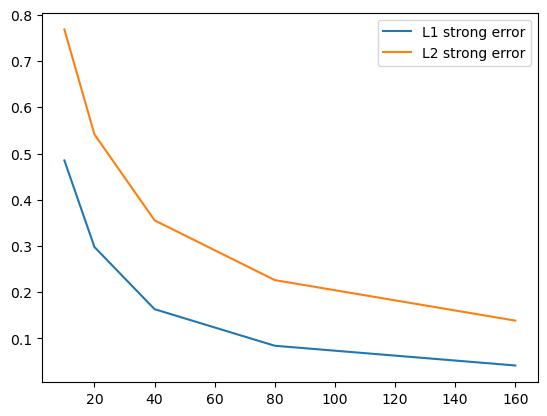

Strong rate of convergence in L^1: 0.8912719963746698
Strong rate of convergence in L^2: 0.6200769352665492


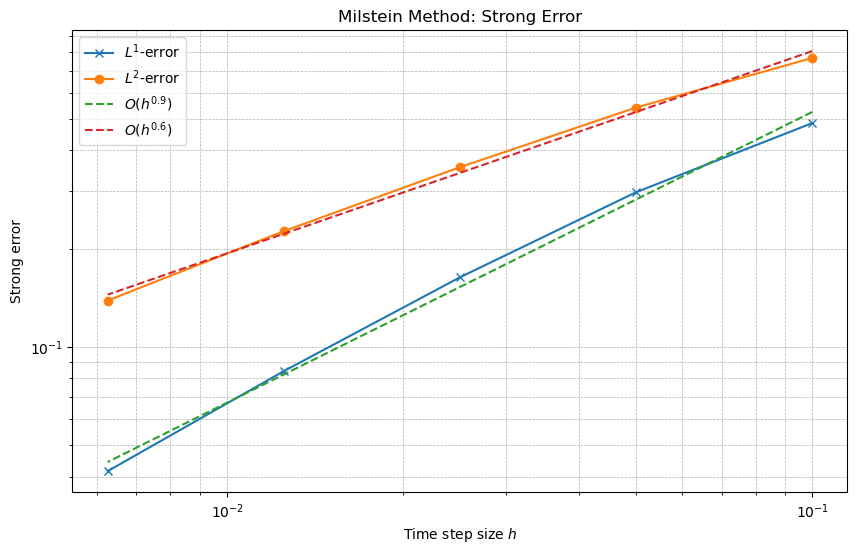

In [8]:
def sigma_2(x):
    return np.sin(1 + x**2)

def sigma_2_P(x):
    return 2*x*np.cos(1 + x**2)

M = 10**5
T = 1
L = [0, 1, 2, 3, 4, 7]
xi = 1
Y_N_l = compute_Milstein(M, T, L, N, mu_1, sigma_2, sigma_2_P, xi)
strong_convergence(L, T, N, Y_N_l)

This absence of convergence in order 1 is due to the fact that the diffussion derivative is not globally bounded, as it depends on X in a multiplicative way, and a cos(), which oscillates between -1 and 1. Hence we cannot apply the strong convergence rate of 1 for all p, for the Milstein scheme.

**Exercise 2**

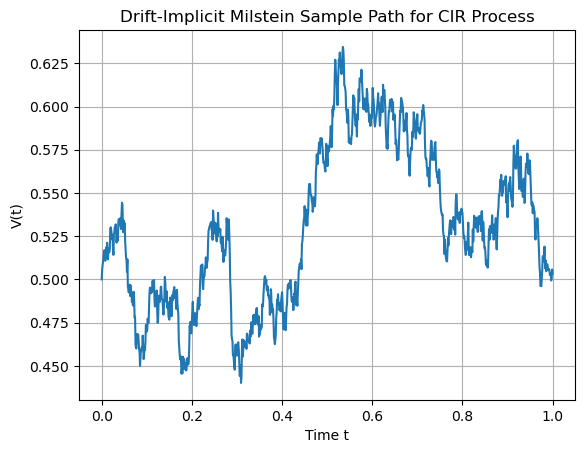

In [9]:
def DriftImplicitMilstein(T, N, v_o, a, b, sigma_v):
    V_N = np.zeros(N+1)
    V_N[0] = v_o
    step = T/N
    W_inc = np.random.normal(0, np.sqrt(step), N, )
    
    for i in range(1, N+1):
        V_N[i] = V_N[i-1] + step * (a*b - sigma_v**2 / 4) + sigma_v * np.sqrt(V_N[i-1]) * W_inc[i-1] + sigma_v**2 / 4 * W_inc[i-1] ** 2
        V_N[i] /= (1 + a*step)
    return V_N

T = 1
N = 1000
v_o = 0.5
a = 2
b = 0.5
sigma_v = 0.25
sample_path = DriftImplicitMilstein(T, N, v_o, a, b, sigma_v)   

x_grid = np.linspace(0, T, N+1)
plt.plot(x_grid, sample_path)
plt.title("Drift-Implicit Milstein Sample Path for CIR Process")
plt.xlabel("Time t")
plt.ylabel("V(t)")
plt.grid()
plt.show()
